In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import json
from tabulate import tabulate

from models.Regression_models import (get_thz_model, 
    get_loss_function, 
    advanced_train_model,
    evaluate_model)
from models.utils import identify_device, display_model
from models.regression_utils import get_train_val_loaders, denormalize_material_params
from torch.utils.data import DataLoader

In [2]:
device = identify_device()

Using device: cuda


In [3]:
file_path = "regression_data/train_3_layer_30k_nonoise_n1to8.pt"

train_loader, val_loader, num_samples = get_train_val_loaders(
    dataset_path=file_path,
    batch_size=128,
    val_split=0.1
)


print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Loading data from regression_data/train_3_layer_30k_nonoise_n1to8.pt
Dataset loaded successfully!
Number of samples: 30000
Shape of input pulse: torch.Size([1, 1024]), target vector: torch.Size([9])
Training batches: 211
Validation batches: 24


In [4]:
# Choose model type: 'advanced' or 'multihead'
model_type = 'advanced'  # Start with this
model = get_thz_model(model_type, input_channels=1, output_dim=9)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Choose loss function: 'weighted', 'multitask', 'smooth_l1'
loss_type = 'weighted'  # This heavily weights k and d parameters
loss_fn = get_loss_function(loss_type)
print(f"Using loss function: {loss_type}")

Total parameters: 7,401,993
Trainable parameters: 7,401,993
Using loss function: weighted


In [5]:
print("=== Testing Overfitting Capability ===")

# Create small dataset for overfitting test
small_dataset = []
count = 0
for batch in train_loader:
    for i in range(len(batch[0])):
        # Keep correct shape: [channels, length]
        small_dataset.append((batch[0][i], batch[1][i]))
        count += 1
        if count >= 32:
            break
    if count >= 32:
        break

# Create small dataloader
small_loader = DataLoader(small_dataset, batch_size=8, shuffle=True)

# Test model on small dataset
test_model = get_thz_model(model_type)
test_loss_fn = get_loss_function(loss_type).to(device)

#print("Training on 32 samples for overfitting test...")
test_model, test_history = advanced_train_model(
    model=test_model,
    train_loader=small_loader,
    val_loader=None,  # No validation for overfitting test
    num_epochs=100,
    initial_lr=1e-2,
    loss_fn=test_loss_fn,
    device=device,
    patience=200,  # High patience for overfitting
    save_best=False
)

print(f"Final training loss on 32 samples: {test_history['train_loss'][-1]:.6f}")
if test_history['train_loss'][-1] < 0.001:
    print("✅ Model can overfit! Architecture is capable.")
else:
    print("⚠️  Model struggling to overfit. May need architecture changes.")

=== Testing Overfitting Capability ===
cuda


Training Progress: 100%|██████████| 100/100 [00:04<00:00, 23.70it/s, train_loss=14.083087, lr=3.47e-06]

Final training loss on 32 samples: 14.083087
⚠️  Model struggling to overfit. May need architecture changes.


In [6]:
metrics, pred_denorm, target_denorm = evaluate_model(test_model, small_loader, denormalize_material_params, device=device)

len(metrics)

9

In [7]:
print("\n=== Starting Full Training ===")

# Fresh model for full training
model = get_thz_model(model_type, input_channels=1, output_dim=9)
loss_fn = get_loss_function(loss_type).to(device)

# Train the model
trained_model, history = advanced_train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=500,  # Much longer training
    initial_lr=1e-3,
    loss_fn=loss_fn,
    denormalize_fn=denormalize_material_params,  # For real-world metrics
    device=device,
    patience=50,    # Early stopping patience
    min_delta=1e-6, # Minimum improvement threshold
    save_best=True,
    model_save_path="best_thz_advanced_model.pt"
)

print("Training completed!")


=== Starting Full Training ===
cuda


Training Progress:  10%|▉         | 49/500 [10:52<1:38:09, 13.06s/it, train_loss=10.231251, val_loss=10.464903, lr=9.77e-04, patience=0/50]


--- Detailed Evaluation at Epoch 50 ---


Training Progress:  10%|█         | 50/500 [10:53<1:39:07, 13.22s/it, train_loss=10.231251, val_loss=10.464903, lr=9.77e-04, patience=0/50]

Parameter-wise RMSE in original units:
  n1: RMSE = 1.79e+00, R² = 0.1881
  k1: RMSE = 2.47e-02, R² = 0.3103
  d1: RMSE = 1.10e-04, R² = 0.2898
  n2: RMSE = 1.59e+00, R² = 0.3775
  k2: RMSE = 2.26e-02, R² = 0.4095
  d2: RMSE = 1.08e-04, R² = 0.3071
  n3: RMSE = 1.77e+00, R² = 0.2039
  k3: RMSE = 2.45e-02, R² = 0.2962
  d3: RMSE = 1.09e-04, R² = 0.2833


Training Progress:  20%|█▉        | 99/500 [21:44<1:27:06, 13.03s/it, train_loss=6.691207, val_loss=8.691976, lr=9.06e-04, patience=1/50]  


--- Detailed Evaluation at Epoch 100 ---


Training Progress:  20%|██        | 100/500 [21:44<1:27:45, 13.16s/it, train_loss=6.691207, val_loss=8.691976, lr=9.06e-04, patience=1/50]

Parameter-wise RMSE in original units:
  n1: RMSE = 1.58e+00, R² = 0.3685
  k1: RMSE = 2.34e-02, R² = 0.3828
  d1: RMSE = 1.02e-04, R² = 0.3845
  n2: RMSE = 1.19e+00, R² = 0.6478
  k2: RMSE = 1.92e-02, R² = 0.5735
  d2: RMSE = 6.96e-05, R² = 0.7141
  n3: RMSE = 1.54e+00, R² = 0.3941
  k3: RMSE = 2.32e-02, R² = 0.3656
  d3: RMSE = 9.98e-05, R² = 0.3985


Training Progress:  30%|██▉       | 148/500 [32:20<1:16:54, 13.11s/it, train_loss=2.756405, val_loss=11.245756, lr=7.99e-04, patience=50/50]


Early stopping triggered after 149 epochs

Best model loaded from epoch 99
Training completed!


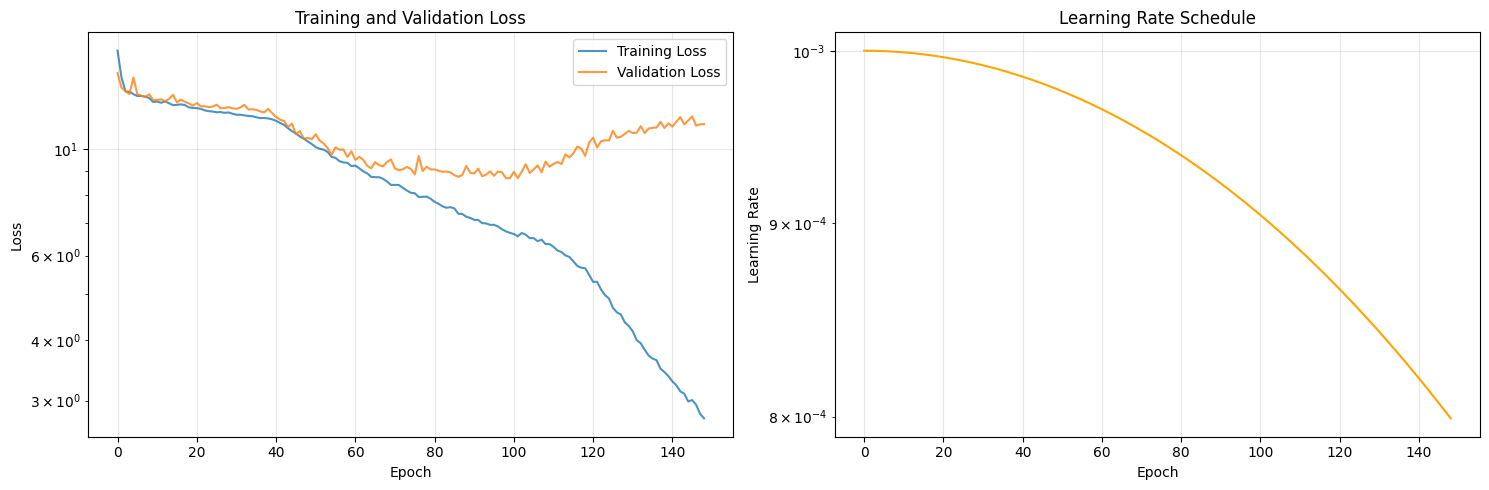

Best validation loss: 8.688767


In [8]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
ax1.plot(history['train_loss'], label='Training Loss', alpha=0.8)
ax1.plot(history['val_loss'], label='Validation Loss', alpha=0.8)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.set_yscale('log')  # Log scale for better visualization
ax1.grid(True, alpha=0.3)

# Learning rate schedule
ax2.plot(history['learning_rate'], color='orange')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Learning Rate')
ax2.set_title('Learning Rate Schedule')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Best validation loss: {min(history['val_loss']):.6f}")

In [9]:
print("\n=== Comprehensive Evaluation ===")

# Evaluate on validation set
metrics, pred_denorm, target_denorm = evaluate_model(
    trained_model, val_loader, denormalize_material_params, device
)

# Create metrics table
table_data = []
target_accuracy = {
    'n1': 0.01, 'n2': 0.01, 'n3': 0.01,
    'k1': 1e-5, 'k2': 1e-5, 'k3': 1e-5,
    'd1': 1e-6, 'd2': 1e-6, 'd3': 1e-6
}

for param, metric in metrics.items():
    target_acc = target_accuracy[param]
    rmse_ratio = metric['rmse'] / target_acc
    meets_target = "✅" if metric['rmse'] <= target_acc else "❌"
    
    table_data.append([
        param,
        f"{metric['rmse']:.2e}",
        f"{metric['mae']:.2e}",
        f"{metric['r2']:.4f}",
        f"{metric['max_error']:.2e}",
        f"{target_acc:.0e}",
        f"{rmse_ratio:.1f}x",
        meets_target
    ])

headers = ['Param', 'RMSE', 'MAE', 'R²', 'Max Error', 'Target', 'Ratio', 'Meets Target']
print(tabulate(table_data, headers=headers, tablefmt='grid'))

# Overall summary
total_meeting_target = sum(1 for param, metric in metrics.items() 
                          if metric['rmse'] <= target_accuracy[param])
print(f"\nParameters meeting target accuracy: {total_meeting_target}/9")


=== Comprehensive Evaluation ===
+---------+----------+----------+--------+-------------+----------+---------+----------------+
| Param   |     RMSE |      MAE |     R² |   Max Error |   Target | Ratio   | Meets Target   |
+=========+==========+==========+========+=============+==========+=========+================+
| n1      | 1.58     | 1.3      | 0.3672 |    5.22     |    0.01  | 158.3x  | ❌             |
+---------+----------+----------+--------+-------------+----------+---------+----------------+
| k1      | 0.0233   | 0.0192   | 0.3876 |    0.0814   |    1e-05 | 2329.3x | ❌             |
+---------+----------+----------+--------+-------------+----------+---------+----------------+
| d1      | 0.000102 | 8.31e-05 | 0.3871 |    0.000318 |    1e-06 | 101.8x  | ❌             |
+---------+----------+----------+--------+-------------+----------+---------+----------------+
| n2      | 1.23     | 0.98     | 0.628  |    4.43     |    0.01  | 122.6x  | ❌             |
+---------+---------

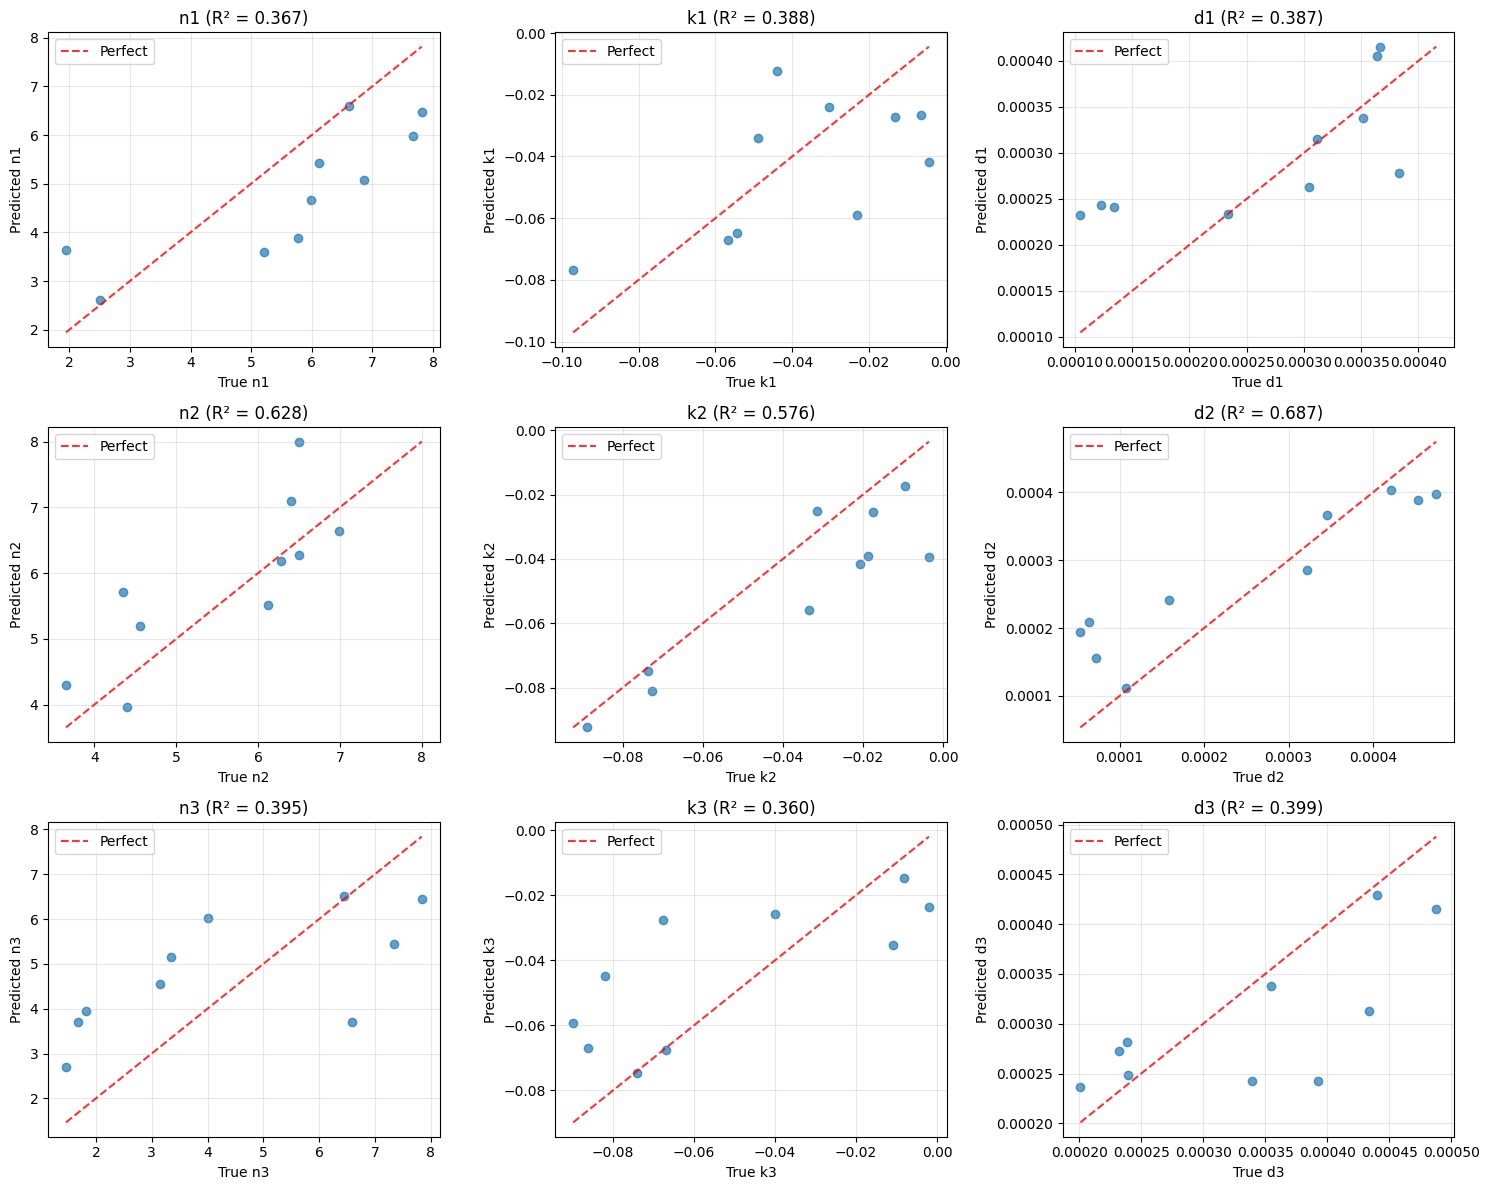

In [10]:
# Get a batch of predictions for visualization
trained_model.eval()
with torch.no_grad():
    sample_batch = next(iter(val_loader))
    inputs, targets = sample_batch
    inputs, targets = inputs.to(device), targets.to(device)
    predictions = trained_model(inputs)
    
    # Denormalize for plotting
    pred_denorm_batch = denormalize_material_params(predictions.cpu())
    target_denorm_batch = denormalize_material_params(targets.cpu())

# Plot predictions vs targets for first few samples
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
param_names = ['n1', 'k1', 'd1', 'n2', 'k2', 'd2', 'n3', 'k3', 'd3']

for i, (ax, param) in enumerate(zip(axes.flat, param_names)):
    pred_vals = pred_denorm_batch[:10, i].numpy()  # First 10 samples
    target_vals = target_denorm_batch[:10, i].numpy()
    
    ax.scatter(target_vals, pred_vals, alpha=0.7)
    
    # Perfect prediction line
    min_val, max_val = min(target_vals.min(), pred_vals.min()), max(target_vals.max(), pred_vals.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, label='Perfect')
    
    ax.set_xlabel(f'True {param}')
    ax.set_ylabel(f'Predicted {param}')
    ax.set_title(f'{param} (R² = {metrics[param]["r2"]:.3f})')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
# Save training history
torch.save(history, 'training_history.pt')

# Save final metrics
metrics_serializable = {}
for param, metric in metrics.items():
    metrics_serializable[param] = {k: float(v) for k, v in metric.items()}

with open('final_metrics.json', 'w') as f:
    json.dump(metrics_serializable, f, indent=2)

print("Results saved!")
print(f"Model saved as: best_thz_advanced_model.pt")
print(f"Training history saved as: training_history.pt") 
print(f"Metrics saved as: final_metrics.json")

# Model summary
print(f"\n=== Final Model Summary ===")
print(f"Model type: {model_type}")
print(f"Total parameters: {total_params:,}")
print(f"Loss function: {loss_type}")
print(f"Best validation loss: {min(history['val_loss']):.6f}")
print(f"Parameters meeting target: {total_meeting_target}/9")

Results saved!
Model saved as: best_thz_advanced_model.pt
Training history saved as: training_history.pt
Metrics saved as: final_metrics.json

=== Final Model Summary ===
Model type: advanced
Total parameters: 7,401,993
Loss function: weighted
Best validation loss: 8.688767
Parameters meeting target: 0/9


In [12]:
# If results aren't good enough, try these variations:

print("\n=== Alternative Configurations to Try ===")
print("1. MultiHead model:")
print("   model = get_thz_model('multihead')")
print("   loss_fn = get_loss_function('multitask')")

print("\n2. Higher learning rate:")
print("   initial_lr=5e-3")

print("\n3. Longer training:")
print("   num_epochs=1000, patience=100")

print("\n4. Different loss weighting:")
print("   Edit WeightedParameterLoss weights in regression_models.py")

print("\nIf overfitting test failed, the architecture needs to be even larger!")


=== Alternative Configurations to Try ===
1. MultiHead model:
   model = get_thz_model('multihead')
   loss_fn = get_loss_function('multitask')

2. Higher learning rate:
   initial_lr=5e-3

3. Longer training:
   num_epochs=1000, patience=100

4. Different loss weighting:
   Edit WeightedParameterLoss weights in regression_models.py

If overfitting test failed, the architecture needs to be even larger!
